In [ ]:
'''
1. モジュールのインポートが行えるように「ObjectDetection」のパスを登録
'''
import sys
# 以下のパスは環境に合わせて変更が必要です
sys.path.append('/content/drive/MyDrive/Colab Notebooks/ObjectDetection')

In [ ]:
'''
2. SSDモデルを生成し、学習済み重みをセット
'''
import torch
from ssd import SSD # SSDクラスをインポート

# VOC2012の正解ラベルのリスト
voc_classes = [
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow',
    'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train',
    'tvmonitor']

# SSDモデルの設定値
ssd_cfg = {
    'classes_num': 21,  # 背景クラスを含めた合計クラス数
    'input_size': 300,  # 画像の入力サイズ
    'dbox_num': [4, 6, 6, 6, 4, 4],  # 出力するDBoxのアスペクト比の種類
    'feature_maps': [38, 19, 10, 5, 3, 1],  # 各sourceの画像サイズ
    'steps': [8, 16, 32, 64, 100, 300],  # DBOXの大きさを決める
    'min_sizes': [30, 60, 111, 162, 213, 264],  # DBOXの大きさを決める
    'max_sizes': [60, 111, 162, 213, 264, 315],  # DBOXの大きさを決める
    'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
}

# 推論モードのSSDモデルを生成
net = SSD(phase="test", cfg=ssd_cfg)
# 学習済みの重みを設定
# 以下のパスは環境に合わせて変更が必要です
net_weights = torch.load(
    '/content/drive/MyDrive/Colab Notebooks/ObjectDetection/weights/ssd300_mAP_77.43_v2.pth',
    map_location={'cuda:0': 'cpu'})

# 重みをロードする
net.load_state_dict(net_weights)
print('SSDモデルの準備完了')

SSDモデルの準備完了


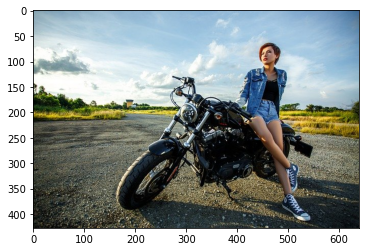

torch.Size([1, 21, 200, 5])
tensor([[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

         [[0.0251, 0.4259, 0.2940, 0.5015, 0.4531],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.00

In [ ]:
'''
3. SSDモデルで物体検出を実施
'''
# PyTorchのバージョンによって発生する無関係な警告
# Named tensors...を出力しないための処理
import warnings
warnings.simplefilter('ignore')

import cv2  # OpenCV2
from voc import DataTransform   # DataTransformクラス
import matplotlib.pyplot as plt # Matplotlib
%matplotlib inline


# 画像の読み込み
# 以下のパスは環境に合わせて変更が必要です
image_file_path = "/content/drive/MyDrive/Colab Notebooks/ObjectDetection/data/girl-6398258_640.jpg"
img = cv2.imread(image_file_path)   # 画像の読み込み[高さ,幅,[B,G,R]]
height, width, channels = img.shape # 画像の高さ、幅、チャネル数を取得

# 画像を出力
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# 前処理クラスを生成
color_mean = (104, 117, 123)  # VOC2012の(BGR)の平均値
input_size = 300              # 画像の入力サイズは300×300
transform = DataTransform(input_size, color_mean)

# 検証用の前処理を実施
phase = 'val'
img_transformed, boxes, labels = transform(
    img,   # 画像
    phase, # 処理モード
    '',    # BBoxの正解座標、正解ラベルはないので''
     '')
# # BGRの並びをRGBの順に変更
img = torch.from_numpy(img_transformed[:, :, (2, 1, 0)]).permute(2, 0, 1)

# SSDで物体検出を実施
net.eval()  # SSDモデルを推論モードにする
x = img.unsqueeze(0) # 0の次元を追加してミニバッチ化(1, 3, 300, 300)
detections = net(x)  # SSDモデルに入力

# detections(1,
#            21[クラス数],
#            200[確信度上位のBBox数],
#            5[確信度、xmin, ymin, xmax, ymax])
print(detections.shape)
# 予測値を出力
print(detections)

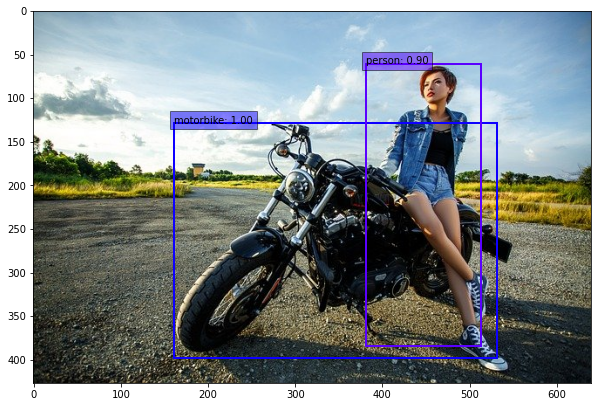

In [ ]:
'''
4. 検出結果を描画
'''
import warnings
warnings.simplefilter('ignore')

import sys
from ssd_predictions import SSDPredictions 

# ファイルパス
# 以下のパスは環境に合わせて変更が必要です
image_file_path = "/content/drive/MyDrive/Colab Notebooks/ObjectDetection/data/girl.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictions(eval_categories=voc_classes, net=net)
# BBoxを抽出する際の閾値を0.6にする
ssd.show(image_file_path, confidence_threshold=0.6)

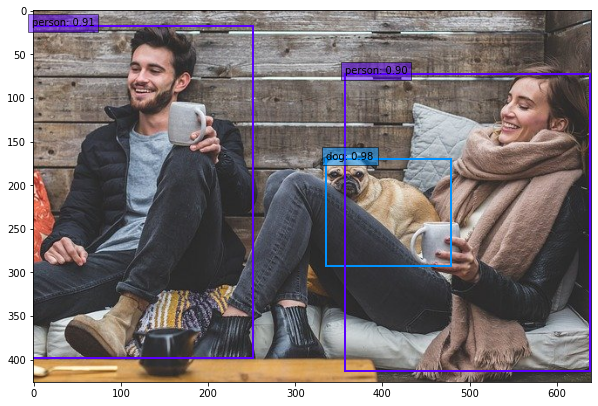

In [ ]:

# ファイルパス
# 以下のパスは環境に合わせて変更が必要です
image_file_path = "/content/drive/MyDrive/Colab Notebooks/ObjectDetection/data/man-2425121_640.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictions(eval_categories=voc_classes, net=net)
# BBoxを抽出する際の閾値を0.6にする
ssd.show(image_file_path, confidence_threshold=0.6)

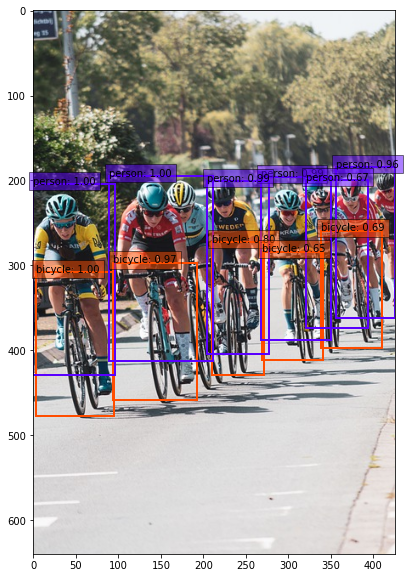

In [ ]:

# ファイルパス
# 以下のパスは環境に合わせて変更が必要です
image_file_path = "/content/drive/MyDrive/Colab Notebooks/ObjectDetection/data/cycling-4397606_640.jpg"

# 予測と、予測結果を画像で描画する
ssd = SSDPredictions(eval_categories=voc_classes, net=net)
# BBoxを抽出する際の閾値を0.6にする
ssd.show(image_file_path, confidence_threshold=0.6)